## Pelargir prototyping

This is a basic notebook to start prototyping a population inference framework for the LISA Global Fit. The statistical formalism was derived by Sharan Banagiri, Alexander Criswell, Pay Meyers, Majo Bustamente, Robbie Rosati, Asad Hussein, Jacob Golomb, and Katerina Chatziioannou at the 2024 LISA Sprint in Pasadena, CA. Prototype code by Alexander Criswell.

The intent of this prototype is to implement the simple "mock Global Fit" blocked Gibbs sampling structure described in the 2025 LPS proposal, "Towards Embedding Population Inference in the LISA Global Fit". 

Contact: Alexander W. Criswell <alexander.criswell.astro@gmail.com>

In [28]:
## imports
import numpyro
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import eryn
from eryn.prior import ProbDistContainer

# import jax.numpy as np
# import jax
# ## make sure we're using full precision
# jax.config.update("jax_enable_x64", True)
# assert(jax.random.uniform(jax.random.key(0), (1,), dtype=jax.numpy.float64).dtype == 'float64')

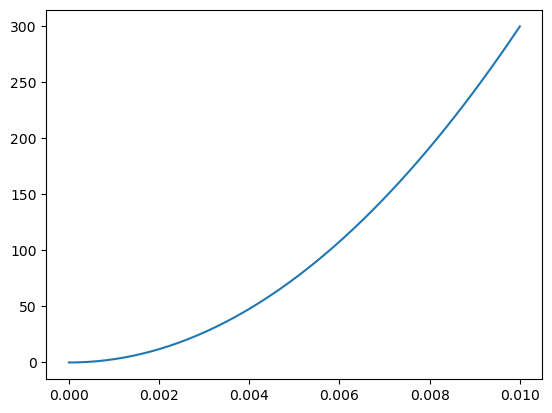

In [39]:
plt.figure()
x = np.linspace(0,0.01)
plt.plot(x,st.powerlaw.pdf(x,3,loc=1e-5,scale=0.01))
plt.show()

In [45]:
class HierarchicalPrior:
    
    '''
    Generic class to handle the population-informed priors.
    
    Arguments
    -------------
    prior_dict (dict) : Dictionary of priors given as {'parameter_name':prior_function,...}
    conditional_map (func) : Function which returns the population-dependent priors given in prior_dict
                             conditioned on the current values of the population parameters given as pop_theta
    kwargs : Any additional values needed by conditional map. These will be added as attributes of the 
             HierarchicalPrior object, such that passing keyward_1=kwarg_1 will set self.keyword_1 = kwarg_1.
    
    '''
    
    def __init__(self,prior_dict,conditional_map,**kwargs):
        ## prior dict of the form {parameter_name:prior_func}
        self.prior_dict = prior_dict
        ## conditional map is a function to condition the above priors on the current values of the population priors
        self.conditional_map = conditional_map
        ## set any additional kwargs needed by conditional_map function as object attributes
        for kw in kwargs:
            setattr(self,kw,kwargs[kw])
        
        return
    
    def condition(self,pop_theta):
        
        self.conditional_dict = self.conditional_map(pop_theta,self.prior_dict)
        
        return


class GaussianGalacticForegroundPrior(HierarchicalPrior):
    '''
    Simple population-informed Galactic foreground prior. Assumes:
    - Gaussian-distributed masses
    - Power-law distributed orbital separations
    - Uniformly distributed inclinations (uniform in cos(i); not population-dependent)
    - (for now) broad Gaussian-distributed distances (TODO: update to an analytic Galaxy model)
    
    Assumes the spectrum is Gaussian and does not account for finite source effects.
    Does not account for truncation of the spectrum (which is due, among other things, to finite source effects).
    '''
    ## set up as below, incorporating mathematical formalism
    ## needs to be in terms of A, alpha...
    
class GalacticBinaryPrior(HierarchicalPrior):
    '''
    Population-informed GB prior. Assumes:
    - Gaussian-distributed masses
    - Power-law distributed orbital separations
    - Uniformly distributed inclinations (uniform in cos(i); not population-dependent)
    - (for now) broad Gaussian-distributed distances (TODO: update to an analytic Galaxy model)
    - (TODO: add sky localization parameters)
    - (TODO: add fdot)
    '''
    
    def __init__(self):
        
        self.prior_dict = {'m_1':st.norm, ## in Msun
                           'm_2':st.norm, ## in Msun
                           'd_L':st.truncnorm, ## in kpc
                           'a':st.powerlaw ## in AU
        }
        
        ## set minimum allowed distance in kpc
        self.d_min = 1e-3 ## no GBs closer than the closest known star
        self.a_min = 1e-5 ## no binaries with a semimajor axis comparable to their radius
        self.a_max = 1e-2 ## no binaries outside of LISA's frequency range
        
        return
    
    def condition(self,pop_theta):
        '''
        Condition the resolved GB parameters on the population parameters.
        
        Arguments:
        ---------------
        pop_theta (dict) : The population parameter chains as produced by Eryn. Keys are population parameter names.
        '''
        
        self.conditional_dict = {}
        ## condition mass prior on current pop values for the mean and standard deviation
        self.conditional_dict['m_1'] = self.prior_dict['m_1'](loc=pop_theta['m_mu'][-1],scale=pop_theta['m_sigma'][-1])
        ## m1 and m2 should come from the same distribution; we can label-switch later if we need to assert m1>m2.
        self.conditional_dict['m_2'] = self.prior_dict['m_2'](loc=pop_theta['m_mu'][-1],scale=pop_theta['m_sigma'][-1])
        ## ensure minimum distance is preserved; 
        ## scipy's truncnorm definition truncates by the number of sigmas, not at a value
        d_trunc = (self.d_min - pop_theta['d_mu'][-1])/pop_theta['d_sigma'][-1] 
        self.conditional_dict['d_L'] = self.prior_dict['d_L'](a=d_trunc,
                                                              b=np.inf,
                                                              loc=pop_theta['d_mu'][-1],
                                                              scale=pop_theta['d_sigma'][-1]
                                                              )
        ## condition semimajor axis prior
        ## NOTE: I am defining this as p(a) ~ a^{alpha}
        ## adding 1 because scipy defines the power law as p(a) ~ a^{alpha - 1} for some reason
        self.conditional_dict['a'] = self.prior_dict['a'](pop_theta['a_alpha']+1,
                                                          loc=self.a_min, ## minimum
                                                          scale=self.a_max ## maximum
                                                         )
        return
    

In [20]:
class Mock_Gibbs_Block:
    
    '''
    Generic class to describe the two mock Gibbs blocks that will sample over deterministic likelihoods,
    conditioned on population-dependent priors.
    
    Arguments:
    ----------------
    log_likelihood (func/obj tbd)    : Joint log likelihood of the block's parameters
    hierarchical_prior (HierarchicalPrior object)  : Population-dependent parameter priors.
    parameters (list of str) : Parameter names for **one** signal. An individual block should only govern one signal type.
    N_signal (int) : Number of signals. N_signal=1 for the Galactic foreground, N_signal >> 1 for the resolved binaries.
    
    '''
    
    def __init__(self,log_likelihood,hierarchical_prior,parameters,N_signal):
        
        self.log_likelihood = log_likelihood
        self.hierarchical_prior = hierarchical_prior 
        
        ## assemble list of parameter names, indexed by signal number
        if N_signal > 1:
            self.parameters = ["{}_{}".format(par_name,i) for par_name in parameters for i in range(N_signal)]
        else:
            self.parameters = parameters
        
        return
    
    def set_conditional_priors(self,pop_theta):
        
        '''
        Function to define the block's current population-informed prior. 
        This will be the hierarchical prior conditioned on the current state of the population block.
        
        Arguments:
        ---------------
        pop_theta (array) : Current values of the population parameters.
        
        '''
        
        ## condition
        self.hierarchical_prior.condition(pop_theta)
        
        ## make the prior dict
        ## the conditional dict gives conditional prior for each parameter
        ## and assumes the parameter priors are the same for all signals
        priors_in = {parameter: self.hierarchical_prior.conditional_dict[parameter.split('_')[0]] for parameter in self.parameters}
        ## update prior
        self.prior = ProbDistContainer(priors_in)## Eryn probdist container
        
        return
    
    def sample(self,N_iter):
        
        '''
        Calls Eryn and samples for N_iter iterations.
        
        
        '''
        ... ## call Eryn to sample over the block parameters with population-informed priors
        return
